# Titanic Top 4% with ensemble modeling

* **1 소개**
* **2 데이터 로드 및 체크**
    * 2.1 데이터 로드 
    * 2.2 이상치 감지
    * 2.3 학습 및 테스트 데이터 세트 조인
    * 2.4 널 및 결측치 
* **3 피처 분석**
    * 3.1 수치형 값
    * 3.2 범주형 값
* **4 결측치 처리**
    * 4.1 Age
* **5 피처 엔지니어링**
    * 5.1 Name/Title
    * 5.2 Family Size
    * 5.3 Cabin
    * 5.4 Ticket
* **6 모델링**
    * 6.1 단순 ML모델
        * 6.1.1 교차 검증 모델
        * 6.1.2 베스트모델에 대한 하이터 파라미터 튜닝
        * 6.1.3 학습곡선 폴롯
        * 6.1.4 트리기반의 분류기에 대한 피처 중요도
    * 6.2 앙상블 모델링
        * 6.2.1 모델 조합
    * 6.3 예측
        * 6.3.1 예측 및 결과 예측
    

## 1. 소개

캐글에서 세번째로 타이타닉 관련 데이터셋을 가지고  다음과 같은 방법으로 진행하려고 한다.

No matter what you're going through, there's a light at the end of the tunnel. 

It may seem hard to get to it, but you can do it.

Just keep working towards to it and you will find the positive side of things.
  [Demi Lovato]

* **피처 분석**
* **피처 엔지니어링**
* **모델링**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve, train_test_split

import warnings
warnings.filterwarnings("ignore")

%cd ../input/titanic/

/kaggle/input/titanic


## 2.데이터 로드 및 데이터 확인
### 2.1 데이터 로드 

* **Read Evaluate Print Loop**

In [2]:
train = pd.read_csv("train.csv")
test  = pd.read_csv("test.csv")
IDTEST = test["PassengerId"]

display(train.shape, test.shape)
display(train.head(n=2), test.tail(n=2))

train_len = train.shape[0]
display("train_lean : ", train_len)

print("기술통계 : \n")
display(train.info())

(891, 12)

(418, 11)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S
417,1309,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C


'train_lean : '

891

기술통계 : 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


None

In [3]:
def load_dataset():
    """
    학습 및 데이터셋 리턴
    기술통계 
    """
    train = pd.read_csv("train.csv")
    test  = pd.read_csv("test.csv")
    IDTEST = test["PassengerId"]  # 결과물제출시 PassengerId
    
    # Shape및 데이터보기
    display(train.shape, test.shape)
    display(train.head(n=2), display(test.tail(n=2)))
    
    train_len = train.shape[0]
    display("train_len : ", train_len)
    
    print("기술통계 \n")
    display(train.info())
    return train, test, IDTEST, train_len

# 수행
train, test, IDTEST, train_len = load_dataset()

(891, 12)

(418, 11)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S
417,1309,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


None

'train_len : '

891

기술통계 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


None

### 2.2 이상치 감지

* **Read Evaluate Print Loop**

In [4]:
outlier_index = []
feature = ["Age", "SibSp", "Parch", "Fare"]

for col in feature:
    # 25%
    Q1 = np.percentile(train[col], 25)
    
    # 75%
    Q3 = np.percentile(train[col], 75)
    
    #IQR(Interquatile Range)
    IQR = Q3 - Q1
    outlier_step = 1.5 * IQR
    
    min_outlier = Q1 - outlier_step
    max_outlier = Q3 + outlier_step
    
    
    outlier_df = train[(train[col] < min_outlier) | (train[col] > max_outlier)]
    outlier_index.extend(outlier_df.index)
    
outlier_index = Counter(outlier_index)    
#display(outlier_index)
display(type(outlier_index))
#display("Moset Common", outlier_index.most_common())

for k, v in outlier_index.items():
    if v >= 2:
        print("키값 : {}, 갯수 : {}".format(k, v))  

collections.Counter

키값 : 7, 갯수 : 2
키값 : 16, 갯수 : 2
키값 : 24, 갯수 : 2
키값 : 27, 갯수 : 3
키값 : 50, 갯수 : 2
키값 : 59, 갯수 : 2
키값 : 63, 갯수 : 2
키값 : 68, 갯수 : 2
키값 : 71, 갯수 : 2
키값 : 88, 갯수 : 3
키값 : 119, 갯수 : 2
키값 : 159, 갯수 : 3
키값 : 164, 갯수 : 2
키값 : 171, 갯수 : 2
키값 : 176, 갯수 : 2
키값 : 180, 갯수 : 3
키값 : 182, 갯수 : 2
키값 : 201, 갯수 : 3
키값 : 229, 갯수 : 2
키값 : 233, 갯수 : 2
키값 : 261, 갯수 : 2
키값 : 266, 갯수 : 2
키값 : 278, 갯수 : 2
키값 : 324, 갯수 : 3
키값 : 341, 갯수 : 3
키값 : 374, 갯수 : 2
키값 : 386, 갯수 : 2
키값 : 409, 갯수 : 2
키값 : 480, 갯수 : 2
키값 : 485, 갯수 : 2
키값 : 541, 갯수 : 2
키값 : 542, 갯수 : 2
키값 : 634, 갯수 : 2
키값 : 642, 갯수 : 2
키값 : 683, 갯수 : 2
키값 : 686, 갯수 : 2
키값 : 787, 갯수 : 2
키값 : 792, 갯수 : 3
키값 : 813, 갯수 : 2
키값 : 819, 갯수 : 2
키값 : 824, 갯수 : 2
키값 : 846, 갯수 : 3
키값 : 850, 갯수 : 2
키값 : 863, 갯수 : 3
키값 : 102, 갯수 : 2
키값 : 118, 갯수 : 2
키값 : 124, 갯수 : 2
키값 : 262, 갯수 : 2
키값 : 268, 갯수 : 2
키값 : 297, 갯수 : 2
키값 : 299, 갯수 : 2
키값 : 305, 갯수 : 2
키값 : 311, 갯수 : 2
키값 : 318, 갯수 : 2
키값 : 319, 갯수 : 2
키값 : 332, 갯수 : 2
키값 : 377, 갯수 : 2
키값 : 390, 갯수 : 2
키값 : 435, 갯수 : 2
키값 : 438

* **모듈화**

In [5]:
def detect_outliers(df, features, n):
    """
    df - DataFrame
    features - feature
    n - 이상치값 필터링에 사용되는 변수값
    
    리턴값 : 이상치의 row index
    """
    outlier_index = []
    
    for col in features:
        # 25%
        Q1 = np.percentile(df[col], 25)
        #75%
        Q3 = np.percentile(df[col], 75)
        
        #Interquatile Range(IQR)
        IQR = Q3 - Q1
        outlier_step = IQR * 1.5
        
        min_cond = Q1 - outlier_step
        max_cond = Q3 + outlier_step
        
        outlier_df = df[(df[col] < min_cond) | (df[col] > max_cond)]
        display("이상치 : \n", outlier_df, outlier_df.shape)
        
        outlier_index.extend(outlier_df.index)
    
    outlier_index = Counter(outlier_index)
    multiple_outliers = [k for k, v in outlier_index.items() if v > n]  
    return multiple_outliers
    
# 이상치탐지
multiple_outliers = detect_outliers(train, ['Age', 'SibSp', 'Parch', 'Fare'], 2)    

'이상치 : \n'

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


(0, 12)

'이상치 : \n'

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
16,17,0,3,"Rice, Master. Eugene",male,2.0,4,1,382652,29.1250,NaN,Q
24,25,0,3,"Palsson, Miss. Torborg Danira",female,8.0,3,1,349909,21.0750,NaN,S
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.0000,C23 C25 C27,S
50,51,0,3,"Panula, Master. Juha Niilo",male,7.0,4,1,3101295,39.6875,NaN,S
59,60,0,3,"Goodwin, Master. William Frederick",male,11.0,5,2,CA 2144,46.9000,NaN,S
63,64,0,3,"Skoog, Master. Harald",male,4.0,3,2,347088,27.9000,NaN,S
68,69,1,3,"Andersson, Miss. Erna Alexandra",female,17.0,4,2,3101281,7.9250,NaN,S
71,72,0,3,"Goodwin, Miss. Lillian Amy",female,16.0,5,2,CA 2144,46.9000,NaN,S
85,86,1,3,"Backstrom, Mrs. Karl Alfred (Maria Mathilda Gu...",female,33.0,3,0,3101278,15.8500,NaN,S


(46, 12)

'이상치 : \n'

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
13,14,0,3,"Andersson, Mr. Anders Johan",male,39.0,1,5,347082,31.2750,NaN,S
16,17,0,3,"Rice, Master. Eugene",male,2.0,4,1,382652,29.1250,NaN,Q
...,...,...,...,...,...,...,...,...,...,...,...,...
871,872,1,1,"Beckwith, Mrs. Richard Leonard (Sallie Monypeny)",female,47.0,1,1,11751,52.5542,D35,S
879,880,1,1,"Potter, Mrs. Thomas Jr (Lily Alexenia Wilson)",female,56.0,0,1,11767,83.1583,C50,C
880,881,1,2,"Shelley, Mrs. William (Imanita Parrish Hall)",female,25.0,0,1,230433,26.0000,NaN,S
885,886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,382652,29.1250,NaN,Q


(213, 12)

'이상치 : \n'

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.0000,C23 C25 C27,S
31,32,1,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",female,NaN,1,0,PC 17569,146.5208,B78,C
34,35,0,1,"Meyer, Mr. Edgar Joseph",male,28.0,1,0,PC 17604,82.1708,NaN,C
52,53,1,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,1,0,PC 17572,76.7292,D33,C
...,...,...,...,...,...,...,...,...,...,...,...,...
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.5500,NaN,S
849,850,1,1,"Goldenberg, Mrs. Samuel L (Edwiga Grabowska)",female,NaN,1,0,17453,89.1042,C92,C
856,857,1,1,"Wick, Mrs. George Dennick (Mary Hitchcock)",female,45.0,1,1,36928,164.8667,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.5500,NaN,S


(116, 12)

이상치(Outlier)는 데이터의 통계치를 왜곡시키기 때문에 때론, 아웃라이어를 통계치에 제외시키기도 한다.

1977년도 Turjey, JW가 발표한 Turkey Method에 방법에 의해 아웃라이어를 찾기위해 IQR에 outlier step만큼 더하거나 뺀 값이 이상치이다.

* **Read Evaluate Print Loop**

In [6]:
display("이상치 삭제전", train.shape)
display(train.iloc[multiple_outliers])
train = train.drop(index = multiple_outliers, axis=0, errors='ignore', inplace=False).reset_index(drop=True)
display("이상치 삭제 후 ", train.shape)

'이상치 삭제전'

(891, 12)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


'이상치 삭제 후 '

(881, 12)

* **모듈화**

In [7]:
def remove_outliers(df, outlier_pos):
    """
    이상치의 데이터프레임에서 인덱스를 매개변수로 받아 
    해당 데이터를 삭제
    """
    display("이상치 삭제전", df.shape)
    display(df.iloc[outlier_pos])
    
    df = df.drop(index = outlier_pos, axis=0, errors='ignore').reset_index(drop=True)
    display("이상치 삭제 후 ", df.shape)
    
    return df

# Remove outlier
# 10개의 아웃라이어
train = remove_outliers(train, multiple_outliers)

'이상치 삭제전'

(881, 12)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q
88,91,0,3,"Christmann, Mr. Emil",male,29.0,0,0,343276,8.0500,NaN,S
159,163,0,3,"Bengtsson, Mr. John Viktor",male,26.0,0,0,347068,7.7750,NaN,S
180,185,1,3,"Kink-Heilmann, Miss. Luise Gretchen",female,4.0,0,2,315153,22.0250,NaN,S
201,207,0,3,"Backstrom, Mr. Karl Alfred",male,32.0,1,0,3101278,15.8500,NaN,S
324,331,1,3,"McCoy, Miss. Agnes",female,NaN,2,0,367226,23.2500,NaN,Q
341,349,1,3,"Coutts, Master. William Loch ""William""",male,3.0,1,1,C.A. 37671,15.9000,NaN,S
792,801,0,2,"Ponesell, Mr. Martin",male,34.0,0,0,250647,13.0000,NaN,S
846,856,1,3,"Aks, Mrs. Sam (Leah Rosen)",female,18.0,0,1,392091,9.3500,NaN,S
863,874,0,3,"Vander Cruyssen, Mr. Victor",male,47.0,0,0,345765,9.0000,NaN,S


'이상치 삭제 후 '

(871, 12)

10개의 이상치 데이터가 발견되었으며 , 28번, 89번 그리고 342번의 승객의 요금이 비정상적으로 높음.

나머지 7개 로우는 매우 높은 SibSp값을 갖고 있다.

### 2.3 학습 데이터셋트와 테스트 데이터세트 조인

* **Read Evaluate Print Loop**

In [8]:
dataset = pd.concat(objs = [train, test], axis = 0).reset_index(drop=True)
display("\n 병합된 데이터셋", dataset.shape)
display("\n Dataset Info ", dataset.info())

'\n 병합된 데이터셋'

(1289, 12)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1289 entries, 0 to 1288
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1289 non-null   int64  
 1   Survived     871 non-null    float64
 2   Pclass       1289 non-null   int64  
 3   Name         1289 non-null   object 
 4   Sex          1289 non-null   object 
 5   Age          1035 non-null   float64
 6   SibSp        1289 non-null   int64  
 7   Parch        1289 non-null   int64  
 8   Ticket       1289 non-null   object 
 9   Fare         1288 non-null   float64
 10  Cabin        292 non-null    object 
 11  Embarked     1287 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 121.0+ KB


'\n Dataset Info '

None

In [9]:
def get_join_dataset(train, test):
    """
    학습 및 테스트 데이터셋을 병합한 데이터셋 
    """
    dataset = pd.concat(objs=[train, test], axis = 0).reset_index(drop=True)
    
    display("\n 병합된 데이터셋 ", dataset.shape)
    
    display("\n Dataset Info ", dataset.info())
    return dataset

# 수행
dataset = get_join_dataset(train, test)

'\n 병합된 데이터셋 '

(1289, 12)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1289 entries, 0 to 1288
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1289 non-null   int64  
 1   Survived     871 non-null    float64
 2   Pclass       1289 non-null   int64  
 3   Name         1289 non-null   object 
 4   Sex          1289 non-null   object 
 5   Age          1035 non-null   float64
 6   SibSp        1289 non-null   int64  
 7   Parch        1289 non-null   int64  
 8   Ticket       1289 non-null   object 
 9   Fare         1288 non-null   float64
 10  Cabin        292 non-null    object 
 11  Embarked     1287 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 121.0+ KB


'\n Dataset Info '

None

### 2.4 널값과 결측치 확인

* **Read Evaluate Print Loop**

In [10]:
print("널값 체크 : \n")
display(dataset.isnull().sum())

print("데이터타입 체크 : \n")
datatype_df = pd.DataFrame(data = dataset.dtypes).reset_index()
datatype_df = datatype_df.rename(columns={"index": "feature", 0: "data_type"}, inplace=False)

display(datatype_df)

print("dataset information : \n")
display(dataset.info())

print("데이터셋 널값 대치\n")
dataset.fillna(np.nan)

print("dataset descriptive statistics : \n")
display(dataset.describe())

display(dataset.head(3))

널값 체크 : 



PassengerId      0
Survived       418
Pclass           0
Name             0
Sex              0
Age            254
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          997
Embarked         2
dtype: int64

데이터타입 체크 : 



,feature,data_type
0,PassengerId,int64
1,Survived,float64
2,Pclass,int64
3,Name,object
4,Sex,object
5,Age,float64
6,SibSp,int64
7,Parch,int64
8,Ticket,object
9,Fare,float64


dataset information : 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1289 entries, 0 to 1288
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1289 non-null   int64  
 1   Survived     871 non-null    float64
 2   Pclass       1289 non-null   int64  
 3   Name         1289 non-null   object 
 4   Sex          1289 non-null   object 
 5   Age          1035 non-null   float64
 6   SibSp        1289 non-null   int64  
 7   Parch        1289 non-null   int64  
 8   Ticket       1289 non-null   object 
 9   Fare         1288 non-null   float64
 10  Cabin        292 non-null    object 
 11  Embarked     1287 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 121.0+ KB


None

데이터셋 널값 대치

dataset descriptive statistics : 



,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1289.000000,871.000000,1289.000000,1035.000000,1289.000000,1289.000000,1288.000000
mean,659.176106,0.384615,2.289372,29.948473,0.453064,0.372382,32.719377
std,377.463798,0.486784,0.838266,14.420747,0.880874,0.858487,50.860006
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,335.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,659.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,987.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.000000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [11]:
def check_null_missing_val(df, datasetT=True):
    """
    널값과 결측치 확인
    trainT 파라미터는 True인 경우는 학습데이터 확인용
    """
    if datasetT:
        # Fill empty and NaNs values with NaN
        df = df.fillna(np.nan)
    
    print("널값 체크 : \n")
    display(df.isnull().sum())

    print("데이터타입 체크 : \n")
    datatype_df = pd.DataFrame(data = df.dtypes).reset_index()
    datatype_df = df.rename(columns={"index": "feature", 0: "data_type"}, inplace=False)

    display(df)

    print("dataset information : \n")
    display(df.info())

    print("dataset descriptive statistics : \n")
    display(df.describe())

    display(df.head(3))
    return df

In [12]:
dataset = check_null_missing_val(dataset, datasetT=True)

널값 체크 : 



PassengerId      0
Survived       418
Pclass           0
Name             0
Sex              0
Age            254
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          997
Embarked         2
dtype: int64

데이터타입 체크 : 



,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
1284,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1285,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1286,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1287,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


dataset information : 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1289 entries, 0 to 1288
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1289 non-null   int64  
 1   Survived     871 non-null    float64
 2   Pclass       1289 non-null   int64  
 3   Name         1289 non-null   object 
 4   Sex          1289 non-null   object 
 5   Age          1035 non-null   float64
 6   SibSp        1289 non-null   int64  
 7   Parch        1289 non-null   int64  
 8   Ticket       1289 non-null   object 
 9   Fare         1288 non-null   float64
 10  Cabin        292 non-null    object 
 11  Embarked     1287 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 121.0+ KB


None

dataset descriptive statistics : 



,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1289.000000,871.000000,1289.000000,1035.000000,1289.000000,1289.000000,1288.000000
mean,659.176106,0.384615,2.289372,29.948473,0.453064,0.372382,32.719377
std,377.463798,0.486784,0.838266,14.420747,0.880874,0.858487,50.860006
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,335.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,659.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,987.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.000000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [13]:
# train데이터셋 확인
train = check_null_missing_val(train)

널값 체크 : 



PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            168
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          670
Embarked         2
dtype: int64

데이터타입 체크 : 



,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
866,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
867,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
868,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
869,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


dataset information : 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 871 entries, 0 to 870
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  871 non-null    int64  
 1   Survived     871 non-null    int64  
 2   Pclass       871 non-null    int64  
 3   Name         871 non-null    object 
 4   Sex          871 non-null    object 
 5   Age          703 non-null    float64
 6   SibSp        871 non-null    int64  
 7   Parch        871 non-null    int64  
 8   Ticket       871 non-null    object 
 9   Fare         871 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     869 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 81.8+ KB


None

dataset descriptive statistics : 



,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,871.000000,871.000000,871.000000,703.000000,871.000000,871.000000,871.000000
mean,447.381171,0.384615,2.300804,29.795405,0.455798,0.362801,31.327233
std,255.836737,0.486784,0.836790,14.539995,0.873655,0.793186,48.228948
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,228.500000,0.000000,2.000000,20.750000,0.000000,0.000000,7.895800
50%,450.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,667.500000,1.000000,3.000000,38.500000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


Age및 Cabin피처는 결측치 처리를 위해서 중요한 역할을 할 수 있다.

## 3. 피처 분석
### 3.1 숫자형 값

* **Read Evaluate Print Loop**

In [14]:
int_cols = train.dtypes[train.dtypes != 'object']
# PassengerId와 Pclass 피처 삭제
int_cols.drop(index = ["PassengerId", "Pclass"], inplace=True)

* **모듈**

In [15]:
def extract_num_features(df, objType=None):
    """
    데이터프레임을 입력받아 데이터타입을 필터링하는 해당 
    피처만 리스트타입으로 리턴
    리턴값은 pd.Series
    """
    int_cols = train.dtypes[train.dtypes != 'object']
    # PassengerId와 Pclass 피처 삭제
    int_cols.drop(index = ["PassengerId", "Pclass"], inplace=True)
    return int_cols  

# 수행
int_cols = extract_num_features(train, 'object')
int_cols.index

Index(['Survived', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')

* **피처들간의 상관관계 보기**

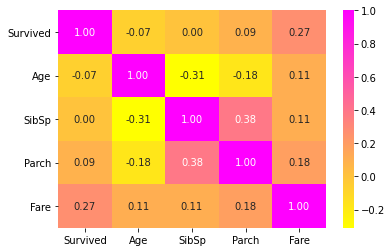

In [16]:
g = sns.heatmap(train[int_cols.index].corr(), annot=True, fmt=".2f", cmap="spring_r")

Fare피처가 생존률과는 의미있는 상관관계를 가지고있습니다. 

그렇다고 해서 다른 피처들이 전혀 필요없다는 의미는 아닙니다. 기존 피처를 이용해 새롭게 파생변수를 생성해보면 상관관계를 새롭게 도출되는 경우도 있습니다. 그런면에서 다른 피처들은 또다른 의미를 갖습니다.

"호랑이는 죽어서 가죽을 남기고 사람은 죽어서 이름을 남긴다."
피처의 소멸 자체도 의미있다는 말씀이지요.

#### SibSP
* [seaborn - factorplot](https://www.kite.com/python/docs/seaborn.factorplot)
* [seaborn - style 사용자 정의](http://hleecaster.com/python-seaborn-set-style-and-context/)

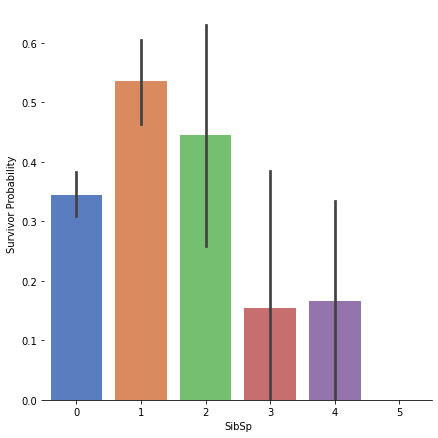

In [17]:
g = sns.factorplot(x="SibSp", y="Survived", data = train, kind="bar", size=6, palette="muted")
g.set_xlabels("SibSp")
g.despine(left=True)  # 좌측의 축을 없앰
g.set_ylabels("Survivor Probability")

동반가족이 2명보다 많은 경우는 생존률이 많이 낮아짐을 알수 있다.
피처 엔지니어링을 통해서 새로운 피처를 추가적으로 도출이 가능하다.

#### Parch

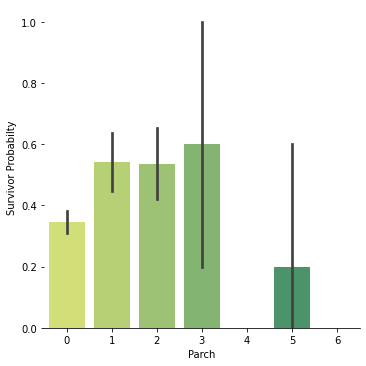

In [18]:
g = sns.factorplot(x="Parch", y="Survived", data = train, palette="summer_r", kind="bar")
g.despine(left=True)
g.set_xlabels("Parch")
g.set_ylabels("Survivor Probabilty")

사이즈가 작은 이동이 생존률이 훨씬 좋은 것을 알수있다. 

동반가족이 3인인 경우, 생존율의 표준편차가 심한 것을 알수 있다.

동반가족여부, 혹은 총 가족수 같은 피처 도출이 필요해보임.

#### Age

* [FacetGrid참조](https://seaborn.pydata.org/generated/seaborn.FacetGrid.html)
* [철학과 데이터사이언스](https://github.com/SANGSEOSEO/philosophy_datascience/blob/master/03.Visualization/Seaborn_FacetGrid.ipynb)

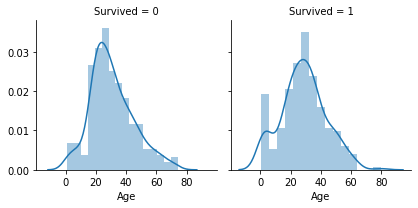

In [19]:
# 히스토그램과 kde plot이 같이.
g = sns.FacetGrid(train, col="Survived")
g = g.map(sns.distplot, "Age")

연령대를 구분할 필요가 있어보임.연령에 대한 사망과 생존의 차이는 크게 두드러지지는 않지만, 연령대가 뒤로 갈수록 사망과 생존의 구별은 확연히 드러날것으로 보임

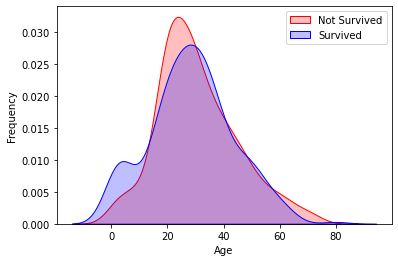

In [20]:
cond_0 = (train["Survived"]== 0) & (train["Age"].notnull())
cond_1 = (train["Survived"]== 1) & (train["Age"].notnull())

g = sns.kdeplot(train["Age"][cond_0], color="red", shade=True)
g = sns.kdeplot(train["Age"][cond_1], color="blue", shade=True, ax = g)

g.set_xlabel("Age")
g.set_ylabel("Frequency")
g.legend(["Not Survived", "Survived"])

Not Survived - density line is put on top of Survived density line. We clearly see a peak corresponsing (between 0 and 5) to babies and youd childresn. 

#### Fare

* **Read Evaluate Print Loop**

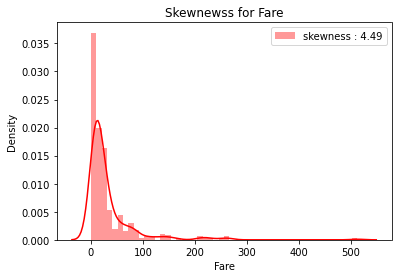

In [21]:
# Fare피처의 편향도
g = sns.distplot(a = dataset["Fare"], color="r", label="skewness : {:.2f}".format(dataset["Fare"].skew()))
g.set_title("Skewnewss for {0}".format(col))
g = g.legend(loc="best")

In [22]:
def show_dist_plot(df, col:str):
    """
    해당 데이터프레임의 피처에 분포 및 kde plot을 시각화
    """
    g = sns.distplot(a=df[col], color="b", label="skewness : {:.2f}".format(df[col].skew()))
    g.set_title("Skewnewss for {0}".format(col))
    g = g.legend(loc="best")

In [23]:
num_cols = int_cols[1:].index.values
display(num_cols)

# 학습 및 테스트 데이터셋 조인한 데이터셋
dataset[num_cols].isnull().sum()

array(['Age', 'SibSp', 'Parch', 'Fare'], dtype=object)

Age      254
SibSp      0
Parch      0
Fare       1
dtype: int64

In [24]:
#Fill Fare missing values with the median value
dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].median())

In [25]:
# Recheck 
dataset["Fare"].isnull().sum()
display(dataset[num_cols].isnull().sum())

Age      254
SibSp      0
Parch      0
Fare       0
dtype: int64

* Check the skewness of Fare feature

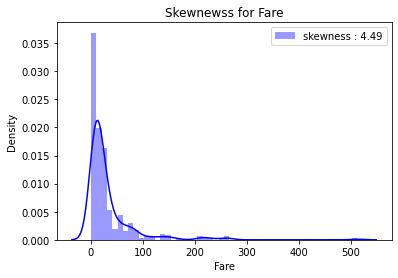

In [26]:
# before logarithm - display Fare Distribution
show_dist_plot(dataset, 'Fare')

As we can see, Fare distribution is very skewed.This can lead to overweight veryl high values in the model, even if it is scaled.

위의 그래프처럼 , Fare band가 매우 편향되어있음을 알수 있다. 이런 데이터를 그냥 모델에 학습시키면 과적합되기 때문에 Min/Max Scaler혹은 Standard Scaler로 정규화 스케일링 후 로그변환을 적용해야 한다.

np.log1p변환과 np.log()변환을 같이 한다면 이때의 편향정도는?
What if we do both np.log1p and np.log ?

* Logarithm transformation

In [27]:
dataset["Fare"] = dataset["Fare"].apply(lambda x: np.log1p(x))
# The following method is also for logarithm
#dataset["Fare"] = dataset["Fare"].map(lambda i: np.log(i) if i > 0 else 0)

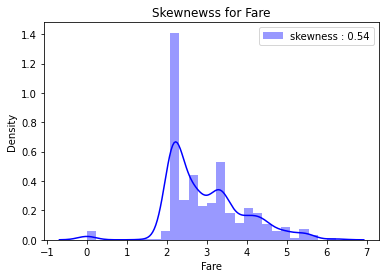

In [28]:
# After logarithm conversion
show_dist_plot(dataset, "Fare")

로그변환 후에 편향정도가 상당히 감소했음을 알 수 있다

### 3.2 범주형 피처의 값

In [29]:
def show_factor_plot(df, xCol=None, yCol=None, col=None, kind='bar', hue=None):
    """
    피처별 생존률 비교
    """
    g = sns.factorplot(x=xCol, y=yCol, hue=hue, col=col, kind=kind, palette="muted", size=6, data = df)
    sns.despine(left=True)  # 왼쪽의 축 제거
    g.set_ylabels(yCol)

#### Sex
* bar plot으로 성별 생존률
* Sex로 Groupby하여 Survived의 mean()값 

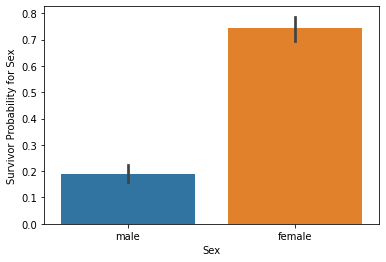

In [30]:
g = sns.barplot(x="Sex", y="Survived", data=train)
g = g.set_ylabel("Survivor Probability for Sex")

In [31]:
train[["Sex", "Survived"]].groupby("Sex").mean()

,Survived
Sex,
female,0.744262
male,0.190813


It is clearly obvious that Male have less chance to survive than Female.

So Sex might play an important role in the prediction of the survival.

For those who have seen the Titanic movie(1997), I am sure that we all remember this script during the evacuation from shipwreckage.

<span style="color:red">**"Women and children first"**</span>

Comparing to the Titanic ,However What do you think about the Sewol ship in Repubic of South Korea in 15th April , 2015.
The only voice from the person in charge was the following.

<span style="color:red">**"Don't go out of the canbin until we sign.Don't stay out of the cabin."**</span>

#### Pclass

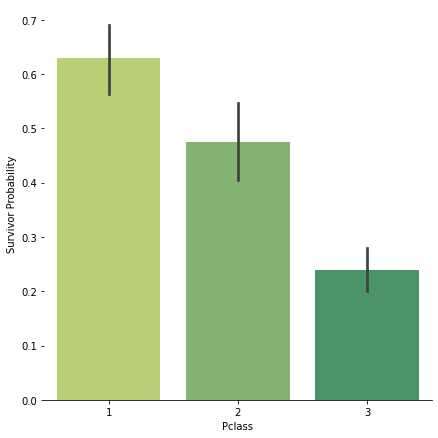

In [32]:
g = sns.factorplot(x = "Pclass", y="Survived", kind='bar', palette="summer_r", size=6, data=train)
g.despine(left=True)
g = g.set_ylabels("Survivor Probability")

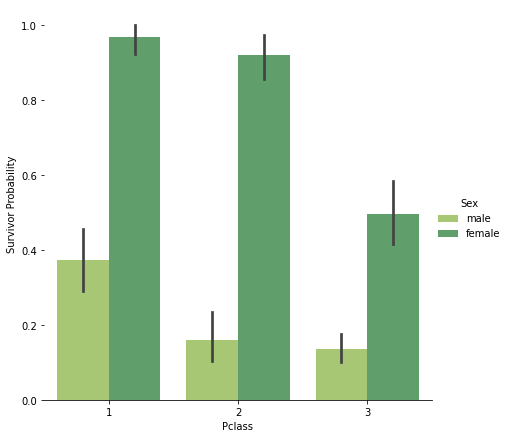

In [33]:
g = sns.factorplot(x = "Pclass", y="Survived", kind='bar', palette="summer_r", hue="Sex", size=6, data=train)
g.despine(left=True)
g = g.set_ylabels("Survivor Probability")

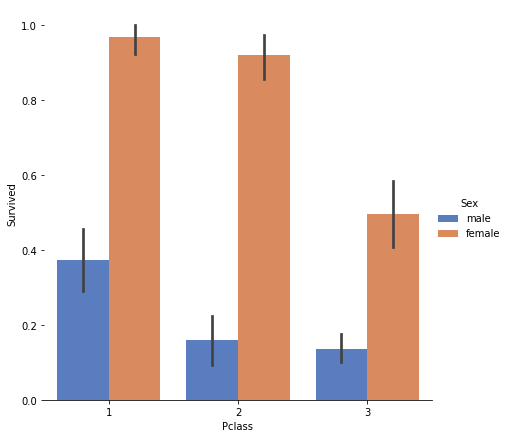

In [34]:
# Explore Pclass vs Survived by Sex
show_factor_plot(train, "Pclass",'Survived', hue='Sex')

The passenger survival is not the same in the 3 classes. First class passengers have more chance to survive than second class and third class passengers.

This trend is conserved when we look at both male and female passengers.

1등급 객실에 있는 승객의 생존률이 다른 여타의 객실에 있는 승객보다 높다는 것은 타이타닉 데이터를 계속 분석하다보면 일관된게 나오는 통찰이다.

#### Embarked

In [35]:
# Embarked피처
dataset["Embarked"].isnull().sum()

2

In [36]:
# 사우스햄튼이 가장 승객이 많다.
dataset["Embarked"].value_counts()

S    896
C    270
Q    121
Name: Embarked, dtype: int64

In [37]:
#Fill Embarked nan values of dataset set with 'S' most frequent value
dataset["Embarked"] = dataset["Embarked"].fillna("S")

In [38]:
# Recheck
dataset["Embarked"].isnull().sum()

0

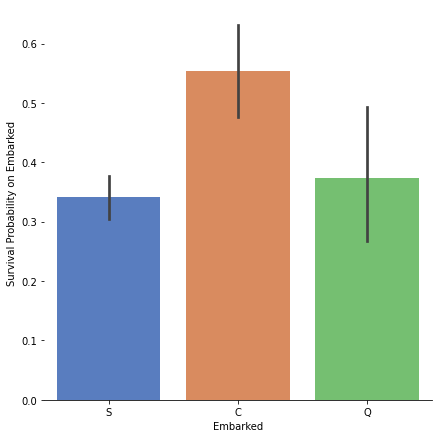

In [39]:
g = sns.factorplot(x = "Embarked", y="Survived", kind="bar", palette="muted", size=6, data=dataset)
g.despine(left=True)
g = g.set_ylabels("Survival Probability on Embarked")

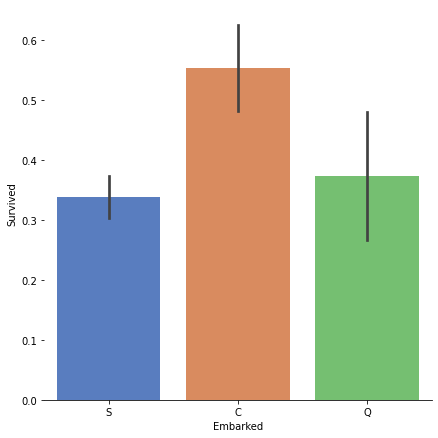

In [40]:
# Explore Embarked vs Survived 
show_factor_plot(train, xCol='Embarked', yCol='Survived')

It seems that passengers from Cherbourg(C) have more chance to survive.

My hypothesis is that the proportion of first class passengers is higher for those who came from Chebourg than Queenstown(Q), Southhamptom(S).

Let's see the Pclass distribution v.s Embarked.

프랑스 노르망디 해안에 위치한 체르보르그항에서 탑승한 승객들의 생존률이 다른 사우스햄튼 혹은 퀸즈타운보다 훨씬 생존률이 좋음을 알 수 있다.

그렇다면, 1등급 객실에 묵은 승객들의 비율이 다른 경유지 항구 - 체르보르그, 사우스햄튼, 퀸즈타운에서 온 승객들보다 더 많을 것이다.

경유지항구(Embarked) v.s Pclass(객실등급)

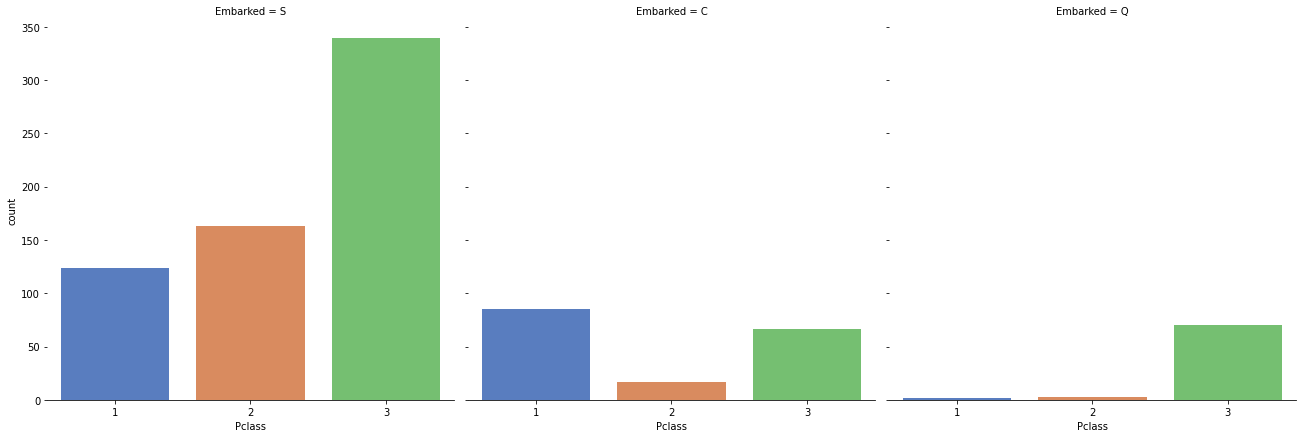

In [41]:
# Explore Pclass vs Embarked 
show_factor_plot(train, xCol='Pclass', col='Embarked', kind='count')

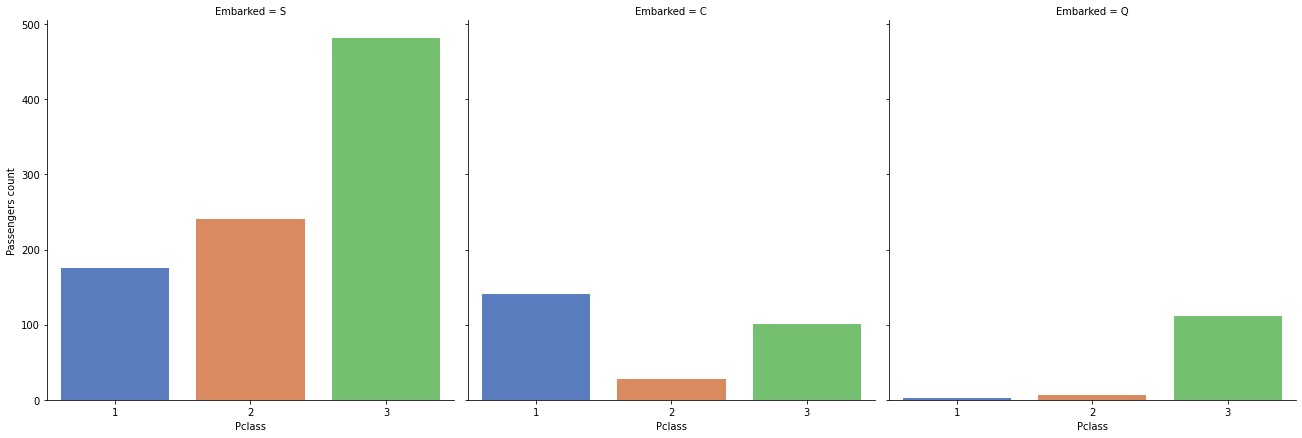

In [42]:
g = sns.factorplot(x="Pclass", col="Embarked", kind="count", size=6, palette="muted", data=dataset)
g = g.set_ylabels("Passengers count")

Indeed, the third class is the moset frequent for passenger coming form Southampton (S) and Queenstown(Q),  whereas Cherbourg passengers are mostly in first class which have the highest survival ratio.

At this point, I can't explain why first class has an higher survival ratio.
My hypothesis is thart first class passengers where prioritised during the evacuation due to their influence.

The difference of survival ratio from passengers between 1st class passengers and 2nd, 3rd class passengers could be ascribed to 1st class passengers's social influence or the Titanic's cabin structure design.

사우스햄튼과 퀸즈타운의 승객들의 대부분은 3등급 객실에 분포되어 있으며, 추론은 이 사망자의 대부분은 퀸즈타운과 사우스햄튼 탑승객 일 것이다.

반면 체르보르그 탑승객들은  1등급이 가장 많다. 

1등급 객실의 생존률이 높은 이유는?
-> 사회적 영향도 인가, 아니면 구조가 용이한 여객선의 구조적 문제인가?

## 4. 결측치 채우기
### 4.1 Age

As we see, Age column contains 256 missing values in the whole dataset.

Since there is subpopulations that have more chance to survive (children for example), It is preferable to keep the age feature and to impute the missing values.

To address this problem, I looked at the moset correlated features with Age(Sex, Parch, Pclass and SibSp)

앞에서 보듯히, Age피처는 256개의 결측치를 포함하고있다.

Age가 속한 연령대에 따라 생존률이 극명하게 갈리는 부분이 있기 때문에 중요한 피처라고 할 수 있으며, 이를 위해서라도 결측치를 대치할 부분이 필요하다.

이를 위해서는 Sex, Parch, Pclass 그리고 SibSp를 이용해 새로운 피처를 생성하는 문제를 생각해보자

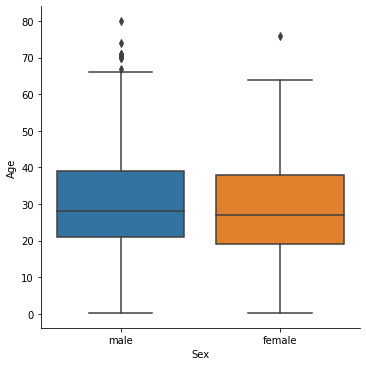

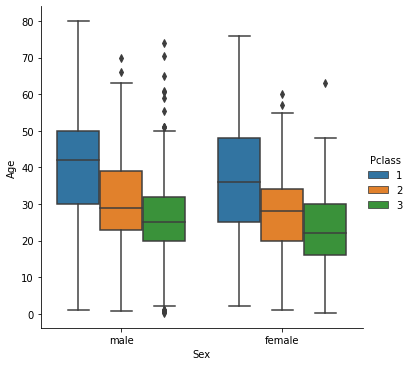

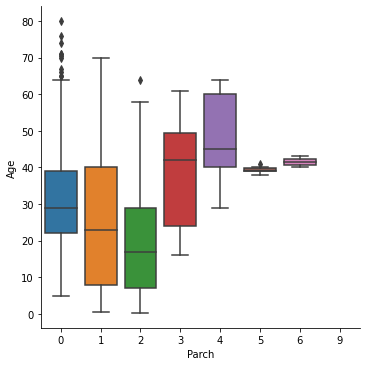

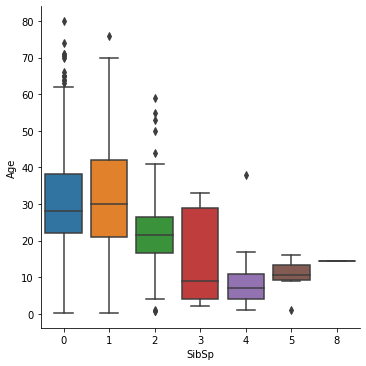

In [43]:
# Explore Age vs Sex, Parch , Pclass and SibSP
g = sns.factorplot(x="Sex", y="Age", data = dataset, kind="box")
g = sns.factorplot(x="Sex", y="Age", hue="Pclass", data = dataset, kind="box")
g = sns.factorplot(x="Parch", y="Age", data = dataset, kind="box")
g = sns.factorplot(x="SibSp", y="Age", data = dataset, kind="box")

Age distribution seems to be the sampe in Male and Female subpopulations, so Sex is not informative to predict Age.

However, 1st class passengers are older than 2nd class passengers who are also older than 3rd class passengers.

Moreover, the more a passenger has parents/children the older he is and the more a passenger has sblings/spouses the younger he is.

성별이 연령대를 예측할 수 있는 결정인자는 아니다.

그러나 1등급 객실에 있는 승객의 나이가 다른 2등급 객실, 3등급 객실의 승객들보다 연령대가 높다는 점은 주목 할 만하다.

부모 및 아이들을 동반한 경우가 자식,배우자를 동반한 경우보다 연령대가 높다는 것을 알 수 있다.

In [44]:
# convert Sex into categoricl value 0 for male and 1 for female
dataset["Sex"] = dataset["Sex"].apply(lambda x: 0 if x =="male" else 1)
# dataset["Sex"] = dataset["Sex"].map({"male":0, "female":1})
dataset.head(n=3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,2.110213,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,4.280593,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,2.188856,NaN,S


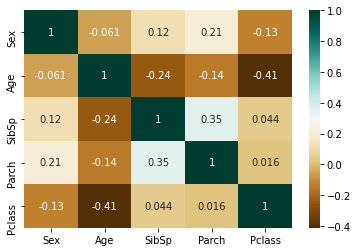

In [45]:
# 앞에서 한번 np.log1p()로 로그변환 한 데이터를 다시 밑에것 np.logp()를 수행하면 
# 히트맵에서 이상하게 보임
df = dataset[["Sex", "Age", "SibSp", "Parch", "Pclass"]]
g = sns.heatmap(df.corr(), cmap="BrBG", annot=True)

The correlation map confirms the factorplots observations except for Parch.

Age is not correlated with Sex, but is negative correlated with Pclass, Parch and SibSp.

In the plot of Age in function of Parch, Age is growing with the number of parents/children.But the general correlation is negative.

So, I decided to use SibSb, Parch and Pclass in order to impute the missing ages.

The strategy is to fill Age with the median age of similar rows accorng to Pclass, Parch and SibSp.

상관관계 맵은 Parch 피처를 제외한 factorplot관측치를 확인합니다. 
Age피처가 Sex랑은 관련성이 떨어지고, Pclass, Parch 그리고 SibSp와 음의 상관관계를 가지고있습니다.

Age피처가 부모 및 아이들의 수에 따라 증가하는 경향은 있지만, 전반적으로는 음의 상관관계입니다.

그래서 Age 결측치를 대치하기 위해 SibSp, Parch 그리고 Pclass를 사용하기로 합니다.(결측치 대치는 median)

* **Read Evaluate Print Loop**

In [46]:
# 자손/배우자 수(SibSp), Parch(부모 + 아이), Pclass(객실등급) = 이 세가지 피처의 값이 같은것의 median()값으로 대치
# 맞는것이 없으면 그냥 Age피처의 median()값으로 대치
cond_age_null = dataset["Age"].isnull()
display(cond_age_null.index)
index_NaN_age = cond_age_null.index.values

for i in index_NaN_age:
    age_med = dataset["Age"].median()
    age_pred = dataset["Age"][((train["SibSp"] == dataset.iloc[i]["SibSp"]) & (dataset["Parch"]==dataset.iloc[i]["Parch"]) & (dataset["Pclass"]==dataset.iloc[i]["Pclass"]))].median()
    
    if not np.isnan(age_pred):
        dataset["Age"].iloc[i] = age_pred
    else:
        dataset["Age"].iloc[i] = age_med

RangeIndex(start=0, stop=1289, step=1)

In [47]:
dataset["Age"].isnull().sum()      

0

* **모듈화**

In [48]:
def fill_missing_value_age(df, index_NaN_age: list):
    """
    자손/배우자 수(SibSp), Parch(부모 + 아이), Pclass(객실등급) = 이 세가지 피처의 값이 같은것의 median()값으로 대치
    맞는것이 없으면 그냥 Age피처의 median()값으로 대치
    """
    for i in index_NaN_age:        
        age_med = df["Age"].median()
        age_pred = df["Age"][((df["SibSp"] == df.iloc[i]["SibSp"]) & (df["Parch"]==df.iloc[i]["Parch"]) & (df["Pclass"]==df.iloc[i]["Pclass"]))].median()

        if not np.isnan(age_pred):
            df["Age"].iloc[i] = age_pred
        else:
            df["Age"].iloc[i] = age_med
    return df

# Age피처 널인것들을 median값으로 대치
dataset = fill_missing_value_age(dataset, index_NaN_age)

* [box v.s violin] (https://junklee.tistory.com/9)

* **Read Evaluate Print Loop**

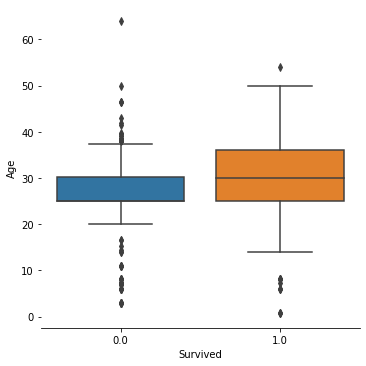

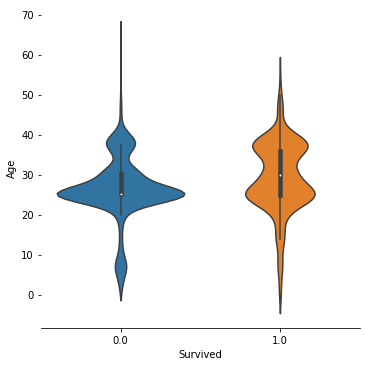

In [49]:
g = sns.factorplot(x="Survived", y="Age", data=dataset, kind = "box")
g.despine(left=True)
g = sns.factorplot(x="Survived", y="Age", data = dataset, kind = "violin")
g.despine(left=True)

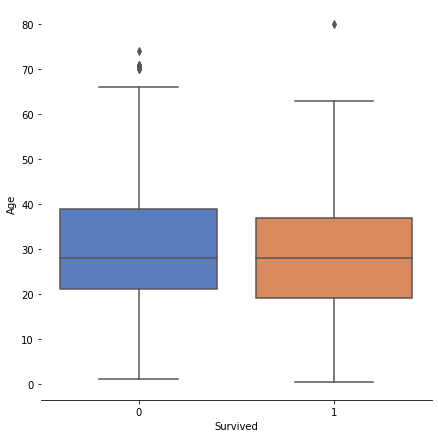

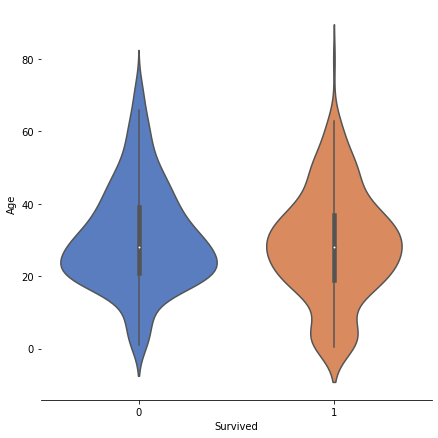

In [50]:
show_factor_plot(train, xCol='Survived', yCol='Age', kind='box')
show_factor_plot(train, xCol='Survived', yCol='Age', kind='violin')

No difference between median value of age in survived and not survived supopulation.

But in the violin plot of survived passengers, we still notice that very young passengers have higher survival rate.

사망자와 생존자의 Age의 median값도 크게 차이가 없다.

violin plot을 보면 나이가 어린 영역대의 생존률이 상당히 높음을 알 수 있다.

## 5. 피처 엔지니어링

In [51]:
def feature_engineering(df, titleOpt=False, familyOpt=False, oneHotEncode=False, ticketT=False, dropFeature=False ,familyAdd=False):
    """
    1.Title에 대한 정제작업
    2.FamilySize 피처 추가 도출 
    3.원핫인코딩  - Title, Embarked
    4.Treat Ticket by extracting the ticket prefix. When there is no prefix it returns X. 
    5.불필요한 피처 삭제
    """    
    if titleOpt:
        # 빈도표를 이용해 해당 피처의 리스트를 구하기 
        titleList = df["Title"].value_counts().index.values.tolist()
        df["Title"] = df["Title"].replace(titleList, ['Mr', 'Miss', 'Mrs', 'Master', 'Mr', 'Other', 'Other', 'Other', 'Miss', 'Miss', 'Mr', 'Other', 'Mr', 'Miss', 'Other', 'Other', 'Mrs', 'Mr'])
        df["Title"] = df["Title"].replace(['Mr','Mrs','Miss','Master','Other'], [0, 1, 2, 3, 4])
        
        # Name feature remove
        df.drop(labels=["Name"], axis = 1, inplace=True, errors="ignore")
        
    if familyOpt:
        try:
            df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
            
            dataset["Single"] = dataset["FamilySize"].map(lambda x: 1 if x == 1 else 0)
            dataset["SmallF"] = dataset["FamilySize"].map(lambda x: 1 if x == 2 else 0)
            dataset["MedF"]   = dataset["FamilySize"].map(lambda x: 1 if 3 <= x <= 4 else 0)
            dataset["LargeF"] = dataset["FamilySize"].map(lambda x: 1 if x >= 5 else 0)
        except KeyError:
            print("이미 삭제 처리된 피처")
        # 피처 추가 후  기존 컬럼 삭제 
        df.drop(labels = ['SibSp', 'Parch'], axis = 1, inplace=True, errors='ignore')  
        
    if familyAdd: # FamilySize의 값에 따라 4개로 분류
        dataset["Single"] = dataset["FamilySize"].map(lambda x: 1 if x == 1 else 0)
        dataset["SmallF"] = dataset["FamilySize"].map(lambda x: 1 if x == 2 else 0)
        dataset["MedF"]   = dataset["FamilySize"].map(lambda x: 1 if 3 <= x <= 4 else 0)
        dataset["LargeF"] = dataset["FamilySize"].map(lambda x: 1 if x >= 5 else 0)
        
    if oneHotEncode:
        cols = ["Title", "Embarked"]
        
        for i in range(len(cols)):
            if i == 0:
                df = pd.get_dummies(df, columns = [cols[i]])                
            else:
                df = pd.get_dummies(df, prefix = 'Em', columns = [cols[i]])
    
    if ticketT:        
        Ticket = []
        for i in list(df["Ticket"]):
            if not i.isdigit():
                Ticket.append(i.replace(".", "").replace("/", "").strip().split(' ')[0])  # 앞의 문자만 추출
            else:
                Ticket.append("X")
        df["Ticket"] = Ticket
        display(df["Ticket"].head(n=2))
    
    #불필요한 컬럼 삭제 
    if dropFeature:
        df.drop(labels=['PassengerId'], axis=1, inplace=True, errors='ignore')    
    
    display(df.head(n=2))
    display(df.tail(n=2))
    return df

### 5.1 Name/Title

In [52]:
display(dataset["Name"].head())

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

The Name feature contains information on passenger's title.

Since some passenger with distingused title may be preferred during the evacuation, it is interesting to add them to the model.

In [53]:
# Get Title from Name
Title = [i.split(',')[1].split('.')[0].strip() for i in dataset["Name"]]
dataset["Title"] = pd.Series(Title)
display(dataset.head())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0.0,3,"Braund, Mr. Owen Harris",0,25.000,1,0,A/5 21171,2.110213,NaN,S,Mr
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,36.000,1,0,PC 17599,4.280593,C85,C,Mrs
2,3,1.0,3,"Heikkinen, Miss. Laina",1,25.125,0,0,STON/O2. 3101282,2.188856,NaN,S,Miss
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,36.000,1,0,113803,3.990834,C123,S,Mrs
4,5,0.0,3,"Allen, Mr. William Henry",0,25.125,0,0,373450,2.202765,NaN,S,Mr


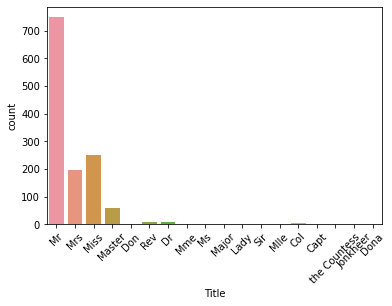

In [54]:
g = sns.countplot(x="Title", data = dataset)
# g.get_xticklabels() - x축의 눈금에 대한 라벨을 보여줌
g = plt.setp(g.get_xticklabels(), rotation=45)

In [55]:
dataset["Title"].value_counts()

Mr              748
Miss            252
Mrs             196
Master           59
Dr                8
Rev               8
Col               4
Mlle              2
Ms                2
Major             2
Dona              1
Capt              1
Don               1
Sir               1
the Countess      1
Lady              1
Jonkheer          1
Mme               1
Name: Title, dtype: int64

There is 17 titles in the dataset, most of then are very rare and we can group them into 4 categories.

In [56]:
dataset = feature_engineering(dataset, titleOpt=True)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0.0,3,0,25.0,1,0,A/5 21171,2.110213,NaN,S,0
1,2,1.0,1,1,36.0,1,0,PC 17599,4.280593,C85,C,1


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
1287,1308,NaN,3,0,25.125,0,0,359309,2.202765,NaN,S,0
1288,1309,NaN,3,0,20.000,1,1,2668,3.150952,NaN,C,3


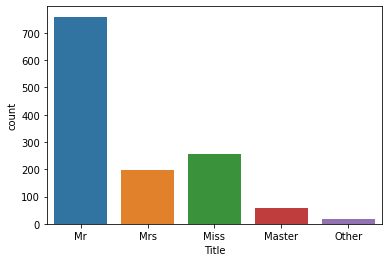

In [57]:
g = sns.countplot(dataset["Title"])
g = g.set_xticklabels(["Mr","Mrs","Miss", "Master", "Other"])

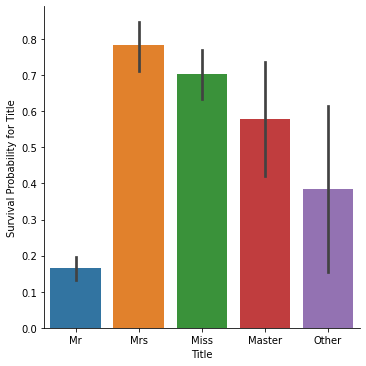

In [58]:
g = sns.factorplot(x="Title", y="Survived", data =dataset, kind="bar")
g = g.set_xticklabels(["Mr","Mrs","Miss", "Master", "Other"])
g = g.set_ylabels("Survival Probability for Title")

"Women and children first"

It is interesting to note that passengers with other title have more chance to survive.

"여자와 아이먼저 구조" 

"Other" 타이틀이 승선객의 Title구성을 볼때 생존률이 높다.

### 5.2 Family size
가족수(FamilySize)피처 추가  - SibSp(동반가족(자손 + 배우자)) , Parch(부모님 동반된 아이들 포함)

* **Read Evaluate Print Loop**

In [59]:
dataset["FamilySize"] = dataset["SibSp"] + dataset["Parch"] + 1
dataset.drop(labels = ["SibSp" , "Parch"], axis = 1, inplace = True, errors="ignore")

* 함수 호출

In [60]:
# Create a family size descriptor from SibSp and Parch
dataset = feature_engineering(dataset, familyOpt=True)

이미 삭제 처리된 피처


,PassengerId,Survived,Pclass,Sex,Age,Ticket,Fare,Cabin,Embarked,Title,FamilySize
0,1,0.0,3,0,25.0,A/5 21171,2.110213,NaN,S,0,2
1,2,1.0,1,1,36.0,PC 17599,4.280593,C85,C,1,2


,PassengerId,Survived,Pclass,Sex,Age,Ticket,Fare,Cabin,Embarked,Title,FamilySize
1287,1308,NaN,3,0,25.125,359309,2.202765,NaN,S,0,1
1288,1309,NaN,3,0,20.000,2668,3.150952,NaN,C,3,3


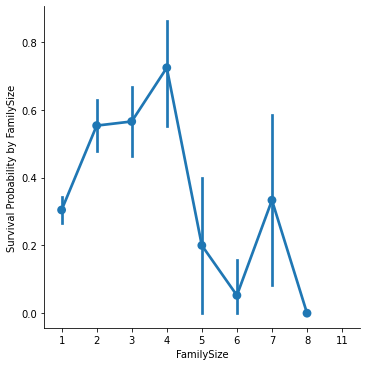

In [61]:
g = sns.factorplot(x="FamilySize", y="Survived", data = dataset)
g = g.set_ylabels("Survival Probability by FamilySize")

The family size seems to play an important role, survival probability is worst for large families.

Additionally, i decided to created 4 categories of family size.

In [62]:
dataset["FamilySize"].value_counts()

1     785
2     233
3     156
4      43
5      22
6      22
7      16
8       8
11      4
Name: FamilySize, dtype: int64

In [63]:
# FamilySize에 따라 피처를 4개로 구분
dataset = feature_engineering(dataset, familyAdd=True)

,PassengerId,Survived,Pclass,Sex,Age,Ticket,Fare,Cabin,Embarked,Title,FamilySize,Single,SmallF,MedF,LargeF
0,1,0.0,3,0,25.0,A/5 21171,2.110213,NaN,S,0,2,0,1,0,0
1,2,1.0,1,1,36.0,PC 17599,4.280593,C85,C,1,2,0,1,0,0


,PassengerId,Survived,Pclass,Sex,Age,Ticket,Fare,Cabin,Embarked,Title,FamilySize,Single,SmallF,MedF,LargeF
1287,1308,NaN,3,0,25.125,359309,2.202765,NaN,S,0,1,1,0,0,0
1288,1309,NaN,3,0,20.000,2668,3.150952,NaN,C,3,3,0,0,1,0


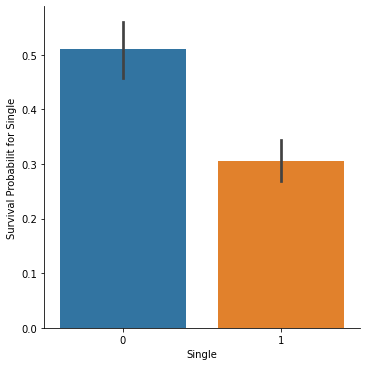

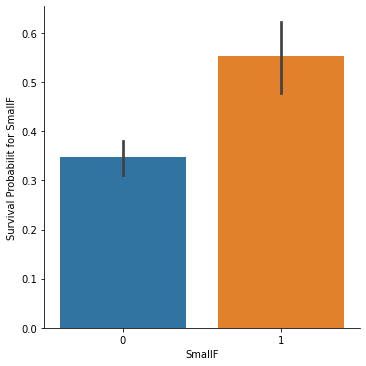

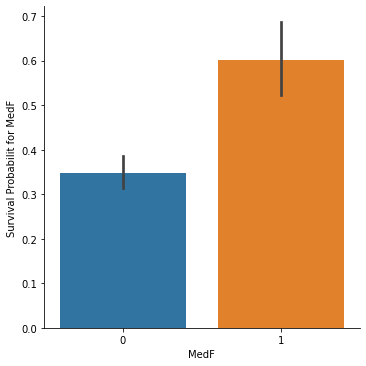

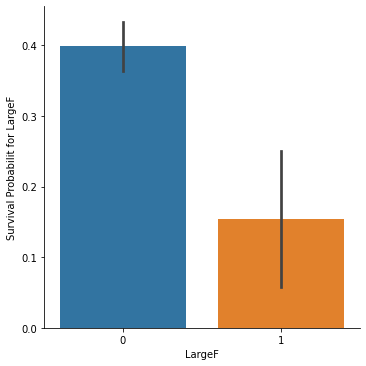

In [64]:
def show_factorplot(df, cols):
    """
    데이터셋과 컬럼에 대한 정보를 받아서 
    Factotplot으로 피처별 생존률을 보여줌
    """
    for i in range(len(cols)):
        g = sns.factorplot(x=cols[i], y='Survived', data=dataset, kind='bar')
        g = g.set_ylabels("Survival Probabilit for {0}".format(cols[i]))   
    
# 피처별 생존률    
cols = ["Single" ,"SmallF", "MedF", "LargeF"]
show_factorplot(dataset, cols)

Factorplots of family size categories show that Small and Medium families have more chance to survive than single passengers and large families.

2인, 3인, 4인정도의 인원으로 가족끼리 탑승한 경우 생존률이 1인 혹은 5인 이상의 가족 및 친지끼리 승선한 경우보다 생존률이 좋다는 점은 기억하자. 

혼자보다 둘이, 둘보다는 세명이서 여행가라. 그러면 사고당해서 돌아오지 못할 확률이 줄어든다.

In [65]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1289 entries, 0 to 1288
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1289 non-null   int64  
 1   Survived     871 non-null    float64
 2   Pclass       1289 non-null   int64  
 3   Sex          1289 non-null   int64  
 4   Age          1289 non-null   float64
 5   Ticket       1289 non-null   object 
 6   Fare         1289 non-null   float64
 7   Cabin        292 non-null    object 
 8   Embarked     1289 non-null   object 
 9   Title        1289 non-null   int64  
 10  FamilySize   1289 non-null   int64  
 11  Single       1289 non-null   int64  
 12  SmallF       1289 non-null   int64  
 13  MedF         1289 non-null   int64  
 14  LargeF       1289 non-null   int64  
dtypes: float64(3), int64(9), object(3)
memory usage: 151.2+ KB


 **One-Hot Encoding Title and Embarked**

In [66]:
#dataset = feature_engineering(dataset, oneHotEncode=True)
dataset = pd.get_dummies(dataset, columns=["Title"])
dataset = pd.get_dummies(dataset, columns=["Embarked"], prefix="Em")

In [67]:
display(dataset.head())
display(dataset.info())

,PassengerId,Survived,Pclass,Sex,Age,Ticket,Fare,Cabin,FamilySize,Single,...,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Title_4,Em_C,Em_Q,Em_S
0,1,0.0,3,0,25.000,A/5 21171,2.110213,NaN,2,0,...,0,0,1,0,0,0,0,0,0,1
1,2,1.0,1,1,36.000,PC 17599,4.280593,C85,2,0,...,0,0,0,1,0,0,0,1,0,0
2,3,1.0,3,1,25.125,STON/O2. 3101282,2.188856,NaN,1,1,...,0,0,0,0,1,0,0,0,0,1
3,4,1.0,1,1,36.000,113803,3.990834,C123,2,0,...,0,0,0,1,0,0,0,0,0,1
4,5,0.0,3,0,25.125,373450,2.202765,NaN,1,1,...,0,0,1,0,0,0,0,0,0,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1289 entries, 0 to 1288
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1289 non-null   int64  
 1   Survived     871 non-null    float64
 2   Pclass       1289 non-null   int64  
 3   Sex          1289 non-null   int64  
 4   Age          1289 non-null   float64
 5   Ticket       1289 non-null   object 
 6   Fare         1289 non-null   float64
 7   Cabin        292 non-null    object 
 8   FamilySize   1289 non-null   int64  
 9   Single       1289 non-null   int64  
 10  SmallF       1289 non-null   int64  
 11  MedF         1289 non-null   int64  
 12  LargeF       1289 non-null   int64  
 13  Title_0      1289 non-null   uint8  
 14  Title_1      1289 non-null   uint8  
 15  Title_2      1289 non-null   uint8  
 16  Title_3      1289 non-null   uint8  
 17  Title_4      1289 non-null   uint8  
 18  Em_C         1289 non-null   uint8  
 19  Em_Q  

None

At this stage, we have 22 features.

### 5.3 Cabin

In [68]:
def display_feature_info(df, feature):
    """
    파라미터로 들어오는 피처에 대해서 기술통계정보, 널값 갯수, 널값이 아닌 갯수를 
    보여줌
    """
    display(df.info())
    display(df[feature].head())
    print("\n")
    display(df[feature].describe())
    
    # 널값 갯수
    display("널값 개수 :", dataset[feature].isnull().sum())
    
    print("\n")
    display(dataset[feature][dataset[feature].notnull()].head(2))
    display(dataset[feature][dataset[feature].notnull()].tail(2))
    
display_feature_info(dataset, 'Cabin')    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1289 entries, 0 to 1288
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1289 non-null   int64  
 1   Survived     871 non-null    float64
 2   Pclass       1289 non-null   int64  
 3   Sex          1289 non-null   int64  
 4   Age          1289 non-null   float64
 5   Ticket       1289 non-null   object 
 6   Fare         1289 non-null   float64
 7   Cabin        292 non-null    object 
 8   FamilySize   1289 non-null   int64  
 9   Single       1289 non-null   int64  
 10  SmallF       1289 non-null   int64  
 11  MedF         1289 non-null   int64  
 12  LargeF       1289 non-null   int64  
 13  Title_0      1289 non-null   uint8  
 14  Title_1      1289 non-null   uint8  
 15  Title_2      1289 non-null   uint8  
 16  Title_3      1289 non-null   uint8  
 17  Title_4      1289 non-null   uint8  
 18  Em_C         1289 non-null   uint8  
 19  Em_Q  

None

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

count                 292
unique                186
top       B57 B59 B63 B66
freq                    5
Name: Cabin, dtype: object

'널값 개수 :'

997

1     C85
3    C123
Name: Cabin, dtype: object

1282     C78
1285    C105
Name: Cabin, dtype: object

Cabin피처는 292개는 값이 존재하고 나머지는 1097개는 널값으로 존재

값이 없는 피처의 값은 'X'로 하고 있는 피처의 값은 앞의 첫글자만 추출해서 보여준다.

**Read Evaluate Print Loop**

In [69]:
for i in dataset["Cabin"]:
    if not pd.isnull(i):
        dataset["Cabin"] = i[0]
    else:
        dataset["Cabin"] = 'X'

**ListComprehensin**

In [70]:
dataset["Cabin"] = [i[0] if not pd.isnull(i) else 'X' for i in dataset["Cabin"]]
cabin_sort = dataset["Cabin"].value_counts().index.values

display(sorted(cabin_sort))

['X']

The first letter of the cabin indicates the Desk, i choosed to keep this information only, since it indicates the probable location of the passenger in the Titanic.

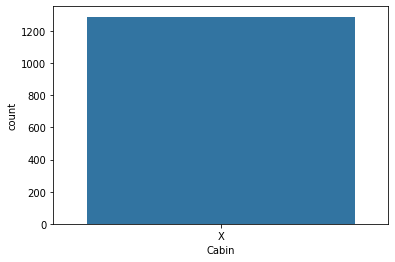

In [71]:
# countplot을 그리되, 정렬순서가 Cabin의 올림차순으로 정렬
g = sns.countplot(dataset["Cabin"], order = sorted(cabin_sort))

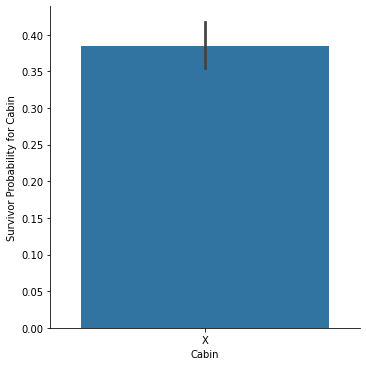

In [72]:
g = sns.factorplot(x="Cabin", y="Survived", data=dataset, kind="bar", order=sorted(cabin_sort))
g = g.set_ylabels("Survivor Probability for Cabin")

Because of the low number of passengers that have a cabin, survival probabilities have an important standard deviation and we can't distinguish between survival probability of passengers in the different desks.

But we can see that passengers with a cabin have generally more chance to survive than passengers without (X).

It is particularly true for cabin B, C, D, E and F.

Cabin피처의 경우 널값을 대체하기전 292개의 값만 널이 아니었기 때문에 크게 의미가 있다고 할순없지만, 값이 있는 피처들의 기준으로만 보면 B, C, D, E, F값을 갖는 Cabin의 경우는 생존률이 높음에 주목하라.

대체적으로 Cabin의 값이 널이었던 'X'의 경우는 생존률이 많이 낮음을 알수있다. 

* One-Hot Encoding

In [73]:
dataset = pd.get_dummies(dataset, columns=["Cabin"], prefix = 'Cabin')

In [74]:
dataset.head(10)

,PassengerId,Survived,Pclass,Sex,Age,Ticket,Fare,FamilySize,Single,SmallF,...,LargeF,Title_0,Title_1,Title_2,Title_3,Title_4,Em_C,Em_Q,Em_S,Cabin_X
0,1,0.0,3,0,25.000000,A/5 21171,2.110213,2,0,1,...,0,1,0,0,0,0,0,0,1,1
1,2,1.0,1,1,36.000000,PC 17599,4.280593,2,0,1,...,0,0,1,0,0,0,1,0,0,1
2,3,1.0,3,1,25.125000,STON/O2. 3101282,2.188856,1,1,0,...,0,0,0,1,0,0,0,0,1,1
3,4,1.0,1,1,36.000000,113803,3.990834,2,0,1,...,0,0,1,0,0,0,0,0,1,1
4,5,0.0,3,0,25.125000,373450,2.202765,1,1,0,...,0,1,0,0,0,0,0,0,1,1
5,6,0.0,3,0,25.125000,330877,2.246893,1,1,0,...,0,1,0,0,0,0,0,1,0,1
6,7,0.0,1,0,38.156250,17463,3.967694,1,1,0,...,0,1,0,0,0,0,0,0,1,1
7,8,0.0,3,0,3.000000,349909,3.094446,5,0,0,...,1,0,0,0,1,0,0,0,1,1
8,9,1.0,3,1,24.750000,347742,2.495954,3,0,0,...,0,0,1,0,0,0,0,0,1,1
9,10,1.0,2,1,29.914461,237736,3.436268,2,0,1,...,0,0,1,0,0,0,1,0,0,1


### 5.4 Ticket

In [75]:
Ticket = []

for i in list(dataset["Ticket"]):
    if not i.isdigit():
        Ticket.append(i.replace(",", "").replace("/", "").strip().split(" ")[0])#앞의 문자만 추출
    else:
        Ticket.append("X")
                    
display(Ticket[1: 10])    

['PC', 'STONO2.', 'X', 'X', 'X', 'X', 'X', 'X', 'X']

In [76]:
display_feature_info(dataset, 'Ticket')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1289 entries, 0 to 1288
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1289 non-null   int64  
 1   Survived     871 non-null    float64
 2   Pclass       1289 non-null   int64  
 3   Sex          1289 non-null   int64  
 4   Age          1289 non-null   float64
 5   Ticket       1289 non-null   object 
 6   Fare         1289 non-null   float64
 7   FamilySize   1289 non-null   int64  
 8   Single       1289 non-null   int64  
 9   SmallF       1289 non-null   int64  
 10  MedF         1289 non-null   int64  
 11  LargeF       1289 non-null   int64  
 12  Title_0      1289 non-null   uint8  
 13  Title_1      1289 non-null   uint8  
 14  Title_2      1289 non-null   uint8  
 15  Title_3      1289 non-null   uint8  
 16  Title_4      1289 non-null   uint8  
 17  Em_C         1289 non-null   uint8  
 18  Em_Q         1289 non-null   uint8  
 19  Em_S  

None

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

count        1289
unique        925
top       CA 2144
freq            8
Name: Ticket, dtype: object

'널값 개수 :'

0

0    A/5 21171
1     PC 17599
Name: Ticket, dtype: object

1287    359309
1288      2668
Name: Ticket, dtype: object

Ticket은 피처의 성격상, 객실의 등급이 티겟번호에 숨어있는 의미가 있기때문에, 우리는 여기서 좀더 있는 의미있는 결과를 위해 Ticket피처의 Prefix를 추출해서 관리하기로 함

In [77]:
## Treat Ticket by extracting the ticket prefix. When there is no prefix it returns X. 
dataset = feature_engineering(dataset, ticketT=True)

0    A5
1    PC
Name: Ticket, dtype: object

,PassengerId,Survived,Pclass,Sex,Age,Ticket,Fare,FamilySize,Single,SmallF,...,LargeF,Title_0,Title_1,Title_2,Title_3,Title_4,Em_C,Em_Q,Em_S,Cabin_X
0,1,0.0,3,0,25.0,A5,2.110213,2,0,1,...,0,1,0,0,0,0,0,0,1,1
1,2,1.0,1,1,36.0,PC,4.280593,2,0,1,...,0,0,1,0,0,0,1,0,0,1


,PassengerId,Survived,Pclass,Sex,Age,Ticket,Fare,FamilySize,Single,SmallF,...,LargeF,Title_0,Title_1,Title_2,Title_3,Title_4,Em_C,Em_Q,Em_S,Cabin_X
1287,1308,NaN,3,0,25.125,X,2.202765,1,1,0,...,0,1,0,0,0,0,0,0,1,1
1288,1309,NaN,3,0,20.000,X,3.150952,3,0,0,...,0,0,0,0,1,0,1,0,0,1


* One-Hot Encoding

In [78]:
dataset = pd.get_dummies(dataset, columns=["Ticket"], prefix = "T")

In [79]:
display(dataset.head(n=2))
display(dataset.info())

,PassengerId,Survived,Pclass,Sex,Age,Fare,FamilySize,Single,SmallF,MedF,...,T_SOTONO2,T_SOTONOQ,T_SP,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X
0,1,0.0,3,0,25.0,2.110213,2,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1.0,1,1,36.0,4.280593,2,0,1,0,...,0,0,0,0,0,0,0,0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1289 entries, 0 to 1288
Data columns (total 57 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1289 non-null   int64  
 1   Survived     871 non-null    float64
 2   Pclass       1289 non-null   int64  
 3   Sex          1289 non-null   int64  
 4   Age          1289 non-null   float64
 5   Fare         1289 non-null   float64
 6   FamilySize   1289 non-null   int64  
 7   Single       1289 non-null   int64  
 8   SmallF       1289 non-null   int64  
 9   MedF         1289 non-null   int64  
 10  LargeF       1289 non-null   int64  
 11  Title_0      1289 non-null   uint8  
 12  Title_1      1289 non-null   uint8  
 13  Title_2      1289 non-null   uint8  
 14  Title_3      1289 non-null   uint8  
 15  Title_4      1289 non-null   uint8  
 16  Em_C         1289 non-null   uint8  
 17  Em_Q         1289 non-null   uint8  
 18  Em_S         1289 non-null   uint8  
 19  Cabin_

None

It could mean that tickets sharing the same prefixes could be booked for cabins placed together.It could therefore lead to the actual placement of the cabins within the ship.

Tickets with sampe prefixes may have a similar class and survival.

So I decided to replace the Tickets feature column by the ticket prefixe/
Which may be more informative.

동일한 티켓번호의 접두사를 갖는 승객의 경우는 동일한 객실과 그에 준하는 생존가능성이 높아질 것으로 추론이 가능

In [80]:
dataset["Pclass"] = dataset["Pclass"].astype("category")
dataset = pd.get_dummies(dataset,co그에 lumns=["Pclass"], prefix="Pc")

In [82]:
# Drop useless variables 
feature_engineering(dataset, dropFeature=True)

,Survived,Sex,Age,Fare,FamilySize,Single,SmallF,MedF,LargeF,Title_0,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,0.0,0,25.0,2.110213,2,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,1.0,1,36.0,4.280593,2,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


,Survived,Sex,Age,Fare,FamilySize,Single,SmallF,MedF,LargeF,Title_0,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
1287,NaN,0,25.125,2.202765,1,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1
1288,NaN,0,20.000,3.150952,3,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1


,Survived,Sex,Age,Fare,FamilySize,Single,SmallF,MedF,LargeF,Title_0,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,0.0,0,25.00000,2.110213,2,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,1.0,1,36.00000,4.280593,2,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,1.0,1,25.12500,2.188856,1,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
3,1.0,1,36.00000,3.990834,2,0,1,0,0,0,...,0,0,0,0,0,0,1,1,0,0
4,0.0,0,25.12500,2.202765,1,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1284,NaN,0,25.12500,2.202765,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1285,NaN,1,38.15625,4.699571,1,1,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1286,NaN,0,25.12500,2.110213,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1287,NaN,0,25.12500,2.202765,1,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1


In [83]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1289 entries, 0 to 1288
Data columns (total 58 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    871 non-null    float64
 1   Sex         1289 non-null   int64  
 2   Age         1289 non-null   float64
 3   Fare        1289 non-null   float64
 4   FamilySize  1289 non-null   int64  
 5   Single      1289 non-null   int64  
 6   SmallF      1289 non-null   int64  
 7   MedF        1289 non-null   int64  
 8   LargeF      1289 non-null   int64  
 9   Title_0     1289 non-null   uint8  
 10  Title_1     1289 non-null   uint8  
 11  Title_2     1289 non-null   uint8  
 12  Title_3     1289 non-null   uint8  
 13  Title_4     1289 non-null   uint8  
 14  Em_C        1289 non-null   uint8  
 15  Em_Q        1289 non-null   uint8  
 16  Em_S        1289 non-null   uint8  
 17  Cabin_X     1289 non-null   uint8  
 18  T_A         1289 non-null   uint8  
 19  T_A4        1289 non-null  

## 6. MODELING

In [90]:
train = dataset[:train.shape[0]]
test = dataset[train.shape[0]:]


display(train.shape)
display(test.shape)

display(train.head(n=2))
display(test.head(n=2))

# remove Survived feature in test datasets
test.drop(labels=["Survived"],axis = 1,inplace=True, errors="ignore")

display(test.head(n=2))

(871, 58)

(418, 58)

,Survived,Sex,Age,Fare,FamilySize,Single,SmallF,MedF,LargeF,Title_0,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,0.0,0,25.0,2.110213,2,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,1.0,1,36.0,4.280593,2,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


,Survived,Sex,Age,Fare,FamilySize,Single,SmallF,MedF,LargeF,Title_0,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
871,NaN,0,25.125,2.178064,1,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1
872,NaN,1,25.000,2.079442,2,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1


,Sex,Age,Fare,FamilySize,Single,SmallF,MedF,LargeF,Title_0,Title_1,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
871,0,25.125,2.178064,1,1,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
872,1,25.000,2.079442,2,0,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1


**Separate train features and label**

In [93]:
train["Survived"] = train["Survived"].astype(int)
Y_train = train["Survived"]  # label dataset
X_train = train.drop(labels=["Survived"], axis = 1)

display(X_train.shape, Y_train.shape)

(871, 57)

(871,)

### 6.1 단순 모델링
#### 6.1.1 교차검증 모델 

10개의 인기있는 분류기를 통해 각각 Stratified KFold교차검증을 이용해 평균 정확도를 평가할 것이다.

* SVC
* Decision Tree
* AdaBoost 
* Random Forest
* Extra Trees
* Gradient Boosting
* Multiple layer perceprton (neural network)
* KNN
* Logistic regression
* Linear Discriminant Analysis

#### **모델 평가**

In [ ]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits = 10)

In [ ]:
def model_evaluation(classifiers, X, y, kfold):
    """
    모델에 대한 예측 정확도 평가 
    """
    cv_results = []
    classifier_name = []
    
    for classifier in classifiers:
        cv_results.append(cross_val_score(classifier, X, y, scoring='accuracy', cv = kfold, n_jobs = 4,verbose=True))
        classifier_name.append(classifier.__class__.__name__)
        
    cv_means = []
    cv_std = []
    
    for cv_result in cv_results:
        cv_means.append(cv_result.mean())
        cv_std.append(cv_result.std())
        
    # 데이터프레임으로 리턴
    cv_res = pd.DataFrame(data = {'CrossValMeans': cv_means, "CrossValerrors": cv_std, "Algorithm": classifier_name})
    
    return cv_res, cv_std, cv_means

#### **수행결과**

#### **모델 평가 수행**

In [ ]:
random_state = 2
svc = SVC(random_state=random_state)
dt_clf = DecisionTreeClassifier(random_state = random_state)
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state), n_estimators=100, learning_rate=0.05,random_state=random_state)
rf_clf  = RandomForestClassifier(n_estimators = 150, n_jobs = -1, random_state=random_state)
ext_clf = ExtraTreesClassifier(random_state=random_state)
grd_clf = GradientBoostingClassifier(learning_rate = 0.5, n_estimators = 500, random_state=random_state)
mlp_clf = MLPClassifier(random_state=random_state)
knn_clf = KNeighborsClassifier(n_neighbors = 10)
lr_clf  = LogisticRegression(random_state = random_state)
lda_clf = LinearDiscriminantAnalysis()

classifiers = []
classifiers.append(svc)
classifiers.append(dt_clf)
classifiers.append(ada_clf)
classifiers.append(rf_clf)
classifiers.append(ext_clf)
classifiers.append(grd_clf)
classifiers.append(mlp_clf)
classifiers.append(knn_clf)
classifiers.append(lr_clf)
classifiers.append(lda_clf)

# 정확도 평가
cv_res, cv_std, cv_means = model_evaluation(classifiers, X_train, Y_train, kfold)

In [ ]:
cv_res, cv_std, cv_means

#### **모델별로 정확도 시각화**

In [ ]:
g = sns.barplot(x="CrossValMeans", y="Algorithm", data=cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross Validation Scores")

앙상블 모델링으로 GradientBoostingClassifier, ExtraTrees, RandomForest, AdaBoost, SVC를 사용할 것임.

#### 6.1.2 최적의 모델을 위한 하이퍼 파라미터 튜닝

GradientBoostingClassifier, ExtraTrees, RandomForest, AdaBoost, SVC를 GridSearchCV를 이용해 하이퍼 파라미터 튜닝

In [ ]:
a = {'국어': [20, 30, 40],'영어':[10, 20, 30], '수학': [20, 56, 90]}

pd.DataFrame(data = a)

* 최적의 ML모델을 가져오기 위한 함수

In [ ]:
def get_best_estimator(models, X_train, Y_train):
    """
    각 모델에 대한 최적의 하이퍼 파라미터를 튜닝
    """
    best_model = []
    best_params = []
    best_score = []
    
    for model in models:
        model.fit(X_train, Y_train)
        
        display("Best Estimator : ", model.best_estimator_)
        display("Best Params : ", model.best_params_)
        display("Best Score : ", model.best_score_)
        
        best_model.append(model.best_estimator_)
        best_params.append(model.best_params_)
        best_score.append(model.best_score_)
        
    result = pd.DataFrame({
                    "Best Model": best_model,
                    "Best Params": best_params,
                    "Best Score":best_score
                 })
    display("모델의 예측 성능 : \n", result)
    return result

* ML모델별 최적화 파라미터 설정

In [ ]:
# AdaBoost
models = []
dt_clf  = DecisionTreeClassifier()
adaDTC = AdaBoostClassifier(dt_clf, random_state=7)

ada_param_grid = {
    'n_estimators': [1, 2, 10, 50],
    'algorithm': ['SAMME', 'SAMME.R'],
    'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]
}
gsadaDTC = GridSearchCV(estimator=adaDTC, param_grid=ada_param_grid, scoring='accuracy', n_jobs=-1, verbose=True, cv=kfold)

models.append(gsadaDTC)
# ExtraTrees
Extc = ExtraTreesClassifier()

ex_param_grid = {
                "criterion": ["gini", "entropy"],
                "max_depth": [None],
                "max_features": [1, 3, 10],
                "min_samples_split": [2, 3, 10],
                "min_samples_leaf": [1, 3, 10],
                "bootstrap": [False],
                "n_estimators" :[100,300]                
}

gsExtc = GridSearchCV(Extc, param_grid=ex_param_grid, scoring='accuracy', n_jobs=-1, verbose=True, cv=kfold)
models.append(gsExtc)

# RandomForestClassifier
rf_clf = RandomForestClassifier()

rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}

gsRfc = GridSearchCV(rf_clf, param_grid=rf_param_grid, scoring='accuracy', n_jobs= -1, verbose=True, cv=kfold)
models.append(gsRfc)


# GradientBoostClassifier
gdb_clf = GradientBoostingClassifier()

gdb_param_grid = {
                'loss': ['deviance', 'exponential'],
                'n_estimators' : [100,200,300],
                'learning_rate': [0.1, 0.05, 0.01],
                'max_depth': [4, 8],
                'min_samples_leaf': [100,150],
                'max_features': [0.3, 0.1]                 
}

gsGdb = GridSearchCV(gdb_clf, gdb_param_grid, scoring='accuracy', n_jobs = -1, cv=kfold)
models.append(gsGdb)

#SVM
svcs = SVC(probability = True)

svc_param_grid = {
    'kernel': ['rbf'],
    'C': [1, 10, 50, 100,200,300, 1000],
    'gamma': [0.001, 0.01, 0.1, 1]
}

gsSvc = GridSearchCV(svcs, param_grid = svc_param_grid, scoring='accuracy', n_jobs = -1, cv = kfold)
models.append(gsSvc)

In [ ]:
result = get_best_estimator(models, X_train, Y_train)

#### 6.1.3 Plot learning curves

학습곡선은 예측 정확도에 대한 학습크기의 효과 및 학습세트에 대한 과적합  결과를 보기위한 좋은 방법입니다.

* [Learning Curve](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html)
* [Data playground](https://dataplay.tistory.com/32?category=855225)

In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [ ]:
for best_model in result["Best Model"]:
    g = plot_learning_curve(best_model, best_model.__class__.__name__ + " learning curves", X_train, Y_train, cv=kfold)

GradientBoosting및 Adaboost 분류기가 학습세트에 과적합의 경향이 보인다.
교차검증횟수가 증가함에 따라, GradientBoosting과 Adaboost가 학습데이터의 크기에 따라 성능이 좋아짐을 보인다.

SVC와 ExtraTrees는 학습점수와 교차검증 점수가 서로 수렴하는 양상을 보이고있다. 

#### 6.1.4 Feature importance of tree based classifiers

승객의 생존률을 예측하기 위한 가장 중요한 피처는 무엇인지 feature_importance를 통해 알아본다.

In [ ]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex='all', figsize=(15, 15))

names_classifiers = [(best_model.__class__.__name__, best_model) for best_model in result["Best Model"]]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        
        indices = np.argsort(classifier.feature_importances_[::-1][:40])
        g = sns.barplot(y = X_train.columns[:40], x = classifier.feature_importances_[:40], orient='h', ax = axes[row, col])
        g.set_xlabel("Relative Importances", fontsize=12)
        g.set_ylabel("Features", fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importances")     
        
        nclassifier += 1

**Age, Sex 그리고 FamilySize가 생존률 예측에 중요 인자**

In [ ]:
predict_series = [pd.Series(best_model.predict(test), name=best_model.__class__.__name__) for best_model in result["Best Model"]] 
ensemble_results = pd.concat(predict_series, axis = 1)

g = sns.heatmap(ensemble_results.corr(), annot=True)

The prediction seems to be quite similar for the 5 classifiers except when Adaboost is compared to the others classifiers.

The 5 classifiers give more or less the same prediction but there is some differences. Theses differences between the 5 classifier predictions are sufficient to consider an ensembling vote. 

### 6.2 앙상블 모델 
#### 6.2.1 ML모델 조합

5개의 ML모델을 사용해 예측한 평가를 앙상블모델을 이용해 soft voting예측(각 모델의 예측의 평균치를 합산)

In [ ]:
votingC = VotingClassifier(estimators= names_classifiers)

votingC.fit(X_train, Y_train)

### 6.3 예측
#### 6.3.1 예측 및 결과 제출

In [ ]:
test_survived = pd.Series(votingC.predict(test), name="Survived")
result = pd.concat([IDTEST, test_survived], axis = 1)

result.to_csv("ensemble_survival_prediction.csv", index=False)